In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# для разделения df на train и test выборку
from sklearn.model_selection import train_test_split
# для подготовки данных
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
# перекрестная проверка модели
from sklearn.model_selection import cross_val_score
# модели
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import validation_curve # для исследования модели
from sklearn.model_selection import StratifiedKFold # для стратифицированной выборки
from sklearn.model_selection import RandomizedSearchCV #импортирует случайный поиск гиперпараметров

In [2]:
df = pd.read_csv('dataset_Facebook.csv')

In [3]:
df = df.dropna (subset=['Paid'])

In [4]:
# разделение выборки на тестовую и учебную
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

X_train = train_set.drop("Paid", axis = 1)
y_train = train_set["Paid"].copy()

X_test = test_set.drop("Paid", axis = 1)
y_test = test_set["Paid"].copy()

X_full = df.drop("Paid", axis = 1)
y_full = df["Paid"].copy()

In [5]:
df_num = df.drop("Type", axis = 1)
df_num = df_num.drop("Paid", axis = 1)

In [6]:
# обработка данных перед обучением

# вставка отсутсвующих значений и маштабирование
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("cat_encoder", OneHotEncoder(sparse=False)),
])

num_attribs = list(df_num)
cat_attribs = ["Type"]

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

X_train_prepared = preprocess_pipeline.fit_transform(X_train[num_attribs + cat_attribs])
X_test_prepared = preprocess_pipeline.fit_transform(X_test[num_attribs + cat_attribs])
X_full_prepared = preprocess_pipeline.fit_transform(X_full[num_attribs + cat_attribs])

/Users/nascela/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/nascela/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/nascela/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497 entries, 0 to 498
Data columns (total 19 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Page total likes                                                     497 non-null    int64  
 1   Type                                                                 493 non-null    object 
 2   Category                                                             497 non-null    int64  
 3   Post Month                                                           497 non-null    int64  
 4   Post Weekday                                                         493 non-null    float64
 5   Post Hour                                                            497 non-null    int64  
 6   Paid                                                                 497 non-null    float64
 7   Lifetime

In [8]:
df.head()

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,Photo,2,12,4.0,3,0.0,2752.0,5091.0,178.0,109.0,159.0,3078.0,1640.0,119.0,4.0,79.0,17.0,100
1,139441,Status,2,12,3.0,10,0.0,10460.0,19057.0,1457.0,1361.0,1674.0,11710.0,6112.0,1108.0,5.0,130.0,29.0,164
2,139441,Photo,3,12,3.0,3,0.0,2413.0,4373.0,177.0,113.0,154.0,2812.0,1503.0,132.0,0.0,66.0,14.0,80
3,139441,Photo,2,12,2.0,10,1.0,50128.0,87991.0,2211.0,790.0,1119.0,61027.0,32048.0,1386.0,58.0,1572.0,147.0,1777
4,139441,Photo,2,12,2.0,3,0.0,7244.0,13594.0,671.0,410.0,580.0,6228.0,3200.0,396.0,19.0,325.0,49.0,393


In [9]:
y = df.Paid
df_preproc = df.drop("Paid", axis = 1)
df_preproc.loc[:, 'Type'] = df.loc[:, 'Type'].replace({'Photo': 0, 'Status': 1, 'Link': 2, 'Video': 3, np.NaN: 4})
imputer = SimpleImputer(strategy="median")
imputer.fit(df_preproc)
X = imputer.transform(df_preproc)
X = pd.DataFrame(X, columns= df_preproc.columns)

/var/folders/4b/wpq4f85s0lzcrjpl4chzpqpw0000gn/T/ipykernel_29393/908241098.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_preproc.loc[:, 'Type'] = df.loc[:, 'Type'].replace({'Photo': 0, 'Status': 1, 'Link': 2, 'Video': 3, np.NaN: 4})


In [10]:
X.head()

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441.0,0.0,2.0,12.0,4.0,3.0,2752.0,5091.0,178.0,109.0,159.0,3078.0,1640.0,119.0,4.0,79.0,17.0,100.0
1,139441.0,1.0,2.0,12.0,3.0,10.0,10460.0,19057.0,1457.0,1361.0,1674.0,11710.0,6112.0,1108.0,5.0,130.0,29.0,164.0
2,139441.0,0.0,3.0,12.0,3.0,3.0,2413.0,4373.0,177.0,113.0,154.0,2812.0,1503.0,132.0,0.0,66.0,14.0,80.0
3,139441.0,0.0,2.0,12.0,2.0,10.0,50128.0,87991.0,2211.0,790.0,1119.0,61027.0,32048.0,1386.0,58.0,1572.0,147.0,1777.0
4,139441.0,0.0,2.0,12.0,2.0,3.0,7244.0,13594.0,671.0,410.0,580.0,6228.0,3200.0,396.0,19.0,325.0,49.0,393.0


In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 18 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Page total likes                                                     497 non-null    float64
 1   Type                                                                 497 non-null    float64
 2   Category                                                             497 non-null    float64
 3   Post Month                                                           497 non-null    float64
 4   Post Weekday                                                         497 non-null    float64
 5   Post Hour                                                            497 non-null    float64
 6   Lifetime Post Total Reach                                            497 non-null    float64
 7   Lifetime

In [12]:
#разбиваем наше множество на 5 частей и перемешиваем "shuffle=True"(Стратифицированная выборка)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [13]:
forest_clf = RandomForestClassifier(n_estimators = 100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train_prepared, y_train, cv = cv, scoring="roc_auc")
forest_scores.mean()

0.5197701980990025

In [14]:
forest_clf = RandomForestClassifier(n_estimators = 100, random_state=42)
forest_scores = cross_val_score(forest_clf, X, y, cv = cv, scoring="roc_auc")
forest_scores.mean()

0.5389640311001813

In [15]:
forest_clf = RandomForestClassifier(n_estimators = 100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_full_prepared, y_full, cv = cv, scoring="roc_auc")
forest_scores.mean()

0.5538367033476579

In [16]:
svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train_prepared, y_train, cv=cv, scoring="roc_auc")
svm_scores.mean()

0.5685053171466214

In [17]:
svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X, y, cv=3, scoring="roc_auc")
svm_scores.mean()

0.5

In [18]:
svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_full_prepared, y_full, cv=3, scoring="roc_auc")
svm_scores.mean()

0.5361131409085373

In [19]:
# выбрали модель - деревья принятия решений
dt_clf = DecisionTreeClassifier(random_state=42)
dt_scores = cross_val_score(dt_clf, X, y, cv=cv, scoring="roc_auc")
dt_scores.mean()

0.5294638199567776

Text(0, 0.5, 'neg_mean_squared_error')

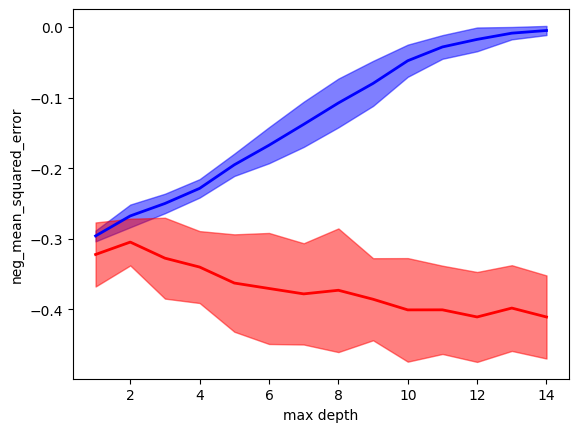

In [20]:
train_scores, valid_scores = validation_curve(
    dt_clf, X_train_prepared, y_train,
    param_name='max_depth',
    param_range=range(1, 15),
    cv=cv,
    scoring='neg_mean_squared_error')

train_score_mean = train_scores.mean(axis=1)
train_score_std = train_scores.std(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)
valid_scores_std = valid_scores.std(axis=1)

plt.fill_between(range(1,15), train_score_mean-train_score_std, train_score_mean+train_score_std, color='b',
                 interpolate=True, alpha=0.5,)
plt.fill_between(range(1,15), valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color='r',
                 interpolate=True, alpha=0.5)

plt.plot(range(1,15), train_score_mean, c='b', lw=2)
plt.plot(range(1,15), valid_scores_mean, c='r', lw=2)

plt.xlabel('max depth')
plt.ylabel('neg_mean_squared_error')

In [21]:
param_grid = {                                 #зададим параметры по которым и будем осуществлять поиск
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 15),
    'min_samples_leaf': range(1, 10),
    'class_weight': [None, 'balanced']}


random_search = RandomizedSearchCV(dt_clf,
                                   param_distributions=param_grid,
                                   n_iter=100, n_jobs=-1,
                                   cv=cv,
                                   scoring='roc_auc',
                                   random_state=42)

random_search.fit(X, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'class_weight': [None, 'balanced'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': range(1, 15),
                                        'min_samples_leaf': range(1, 10)},
                   random_state=42, scoring='roc_auc')

In [22]:
random_search.best_params_ #выведем наилучшие параметры

{'min_samples_leaf': 1,
 'max_depth': 4,
 'criterion': 'entropy',
 'class_weight': None}

In [23]:
random_search.best_score_

0.5962605364698479

In [24]:
best_model = random_search.best_estimator_
best_model #параметры наилучшей модели

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)

In [34]:
imp = best_model.feature_importances_
pd.Series(index=df_preproc.columns, data = imp).sort_values()

Type                                                                   0.000000
Post Month                                                             0.000000
Post Weekday                                                           0.000000
Post Hour                                                              0.000000
share                                                                  0.000000
Lifetime Post Consumers                                                0.000000
like                                                                   0.000000
Lifetime Post Impressions by people who have liked your Page           0.000000
comment                                                                0.000000
Category                                                               0.044166
Lifetime Post reach by people who like your Page                       0.065588
Total Interactions                                                     0.076595
Lifetime People who have liked your Page